# Vector Reflectivity Equation Comparison

This notebook compares the forward and adjoint operators of different forms of the vector reflectivity based acoustic wave equation.

In [56]:
import numpy as np
from devito import *
from examples.seismic import setup_geometry, demo_model, RickerSource, Receiver, plot_velocity

import matplotlib.pyplot as plt

## Source and receivers creators


In [57]:
# Function to create sources and receivers
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec


# Function to create adjoint sources
def adjoint_src(model, geometry, src_pos):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=1)

    srca.coordinates.data[:, 0] = src_pos[0]
    srca.coordinates.data[:, 1] = src_pos[1]

    return srca

## Acquisition geometry and model

In [58]:
# Parameters

NX = 20
NZ = 25

SHAPE = (NX, NZ)
SPACING = (15., 15.)
NLAYERS = 2
SPACE_ORDER = 2
TIME_ORDER = 2
DTYPE = np.float64

preset_params = {
    'layers-viscoacoustic': {
        'nlayers': NLAYERS, 'shape': SHAPE, 'spacing': SPACING,
        'space_order': SPACE_ORDER, 'dtype': DTYPE
    },
    'layers-isotropic': {
        'nlayers': NLAYERS, 'shape': SHAPE, 'b': np.ones(SHAPE),
        'spacing': SPACING, 'space_order': SPACE_ORDER, 'dtype': DTYPE
    },
}

preset = 'layers-isotropic'

In [59]:
model = demo_model(preset, **preset_params[preset])

Operator `initdamp` ran in 0.01 s


In [60]:
tn = 500.
f0 = 0.010

geometry = setup_geometry(model, tn, f0)

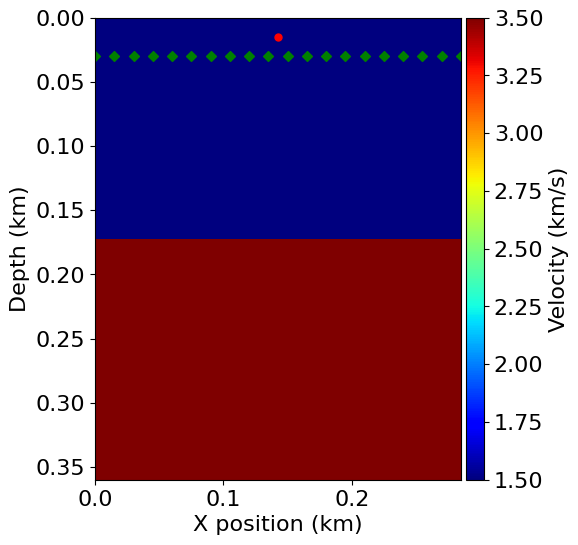

In [61]:
plot_velocity(model, geometry.src_positions, geometry.rec_positions)

## Operators

In [62]:
class OpWrapper():
    def __init__(self, forward, adjoint):
        self.forward = forward
        self.adjoint = adjoint

    def __call__(self, model, geometry, src, rec):
        return self.forward(model, geometry, src, rec)
    
    def T(self, model, geometry, rec, srca=None):
        return self.adjoint(model, geometry, rec, srca)

### Default

In [63]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - 1/vp * div(vp*grad(u, .5), -.5) + 2 * div(u * r, -.5)\
          - 2 * u * div(r, -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=model.critical_dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - div(vp * grad(v/vp, .5), -.5) - 2 * r.T * grad(v, .5)\
        - 2 * v * div(r, -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=model.critical_dt)
    return v

L_default = OpWrapper(forward, adjoint)

### Forward as backward

In [64]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - 1/vp * div(vp*grad(u, .5), -.5) + 2 * div(u * r, -.5)\
          - 2 * u * div(r, -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=model.critical_dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - 1/vp * div(vp*grad(v, .5), -.5) + 2 * div(v * r, -.5)\
          - 2 * v * div(r, -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=model.critical_dt)
    return v

L_self_adjoint = OpWrapper(forward, adjoint)

### Original paper

In [65]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - (u.laplace + 1/vp*grad(vp).T * grad(u) - 2*r.T * grad(u)) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=model.critical_dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - (v.laplace + div(1/vp * grad(vp) * v) - 2 * div(r*v)) \
          + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=model.critical_dt)
    return v

L_original = OpWrapper(forward, adjoint)

## Comparison

In [66]:
src_pos = np.array([model.domain_size[0]/2, model.grid.spacing[1]], DTYPE)
rec_depth = model.domain_size[1]/2
nrec = 1

In [67]:
src_default, rec_default = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_default = adjoint_src(model, geometry, src_pos)

u_default = L_default(model, geometry, src_default, rec_default)
v_default = L_default.T(model, geometry, rec_default, srca_default)

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [68]:
src_self_adjoint, rec_self_adjoint = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_self_adjoint = adjoint_src(model, geometry, src_pos)

u_self_adjoint = L_self_adjoint(model, geometry, src_self_adjoint, rec_self_adjoint)
v_self_adjoint = L_self_adjoint.T(model, geometry, rec_self_adjoint, srca_self_adjoint)

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


In [69]:
src_original, rec_original = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_original = adjoint_src(model, geometry, src_pos)

u_original = L_original(model, geometry, src_original, rec_original)
v_original = L_original.T(model, geometry, rec_original, srca_original)

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


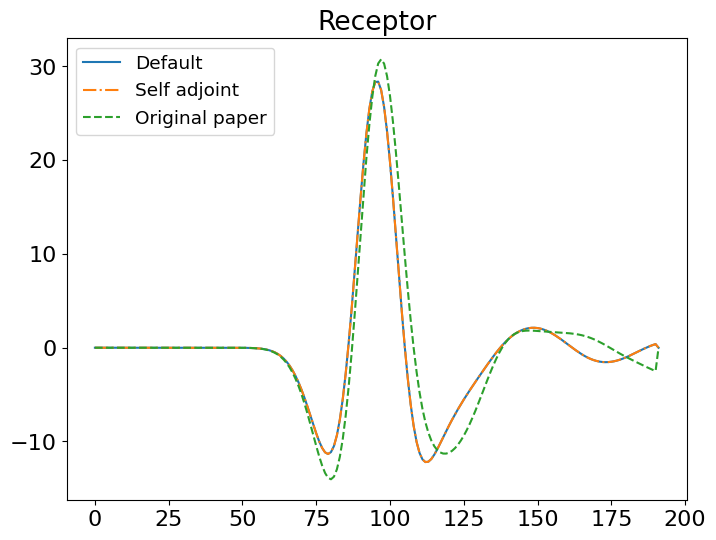

In [75]:
plt.plot(rec_default.data, label='Default')
plt.plot(rec_self_adjoint.data, '-.', label='Self adjoint')
plt.plot(rec_original.data, '--', label='Original paper')

plt.legend(loc='upper left', fontsize='small')
plt.title('Receptor')

plt.show()

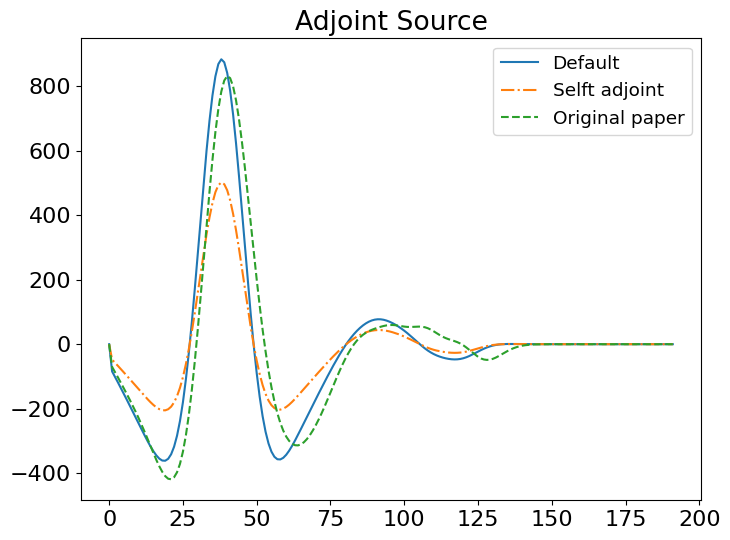

In [74]:
plt.plot(srca_default.data, label='Default')
plt.plot(srca_self_adjoint.data, '-.', label='Selft adjoint')
plt.plot(srca_original.data, '--', label='Original paper')

plt.legend(loc='upper right', fontsize='small')
plt.title('Adjoint Source')

plt.show()